<a href="https://colab.research.google.com/drive/1eQOkYB4XMQdSeHV_pKvt9kSUW8vQo6LQ">Abre este Jupyter en Google Colab</a>

# Regresión Logística: Detección de SPAM

En este ejercicio se muestran los fundamentos de la Regresión Logística planteando uno de los primeros problemas que fueron solucionados mediante el uso de técnicas de Machine Learning: la detección de SPAM.

In [1]:
# Importar Librerias
import os
import email
import string
import nltk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Descargar stopwords de NLTK
nltk.download('stopwords')

# Clase de preprocesamiento
class Parser:
    def __init__(self):
        self.stemmer = nltk.PorterStemmer()
        self.stopwords = set(nltk.corpus.stopwords.words('english'))
        self.punctuation = list(string.punctuation)

    def parse(self, email_path):
        with open(email_path, errors='ignore') as e:
            msg = email.message_from_file(e)
        return None if not msg else self.get_email_content(msg)

    def get_email_content(self, msg):
        subject = self.tokenize(msg['Subject']) if msg['Subject'] else []
        body = self.get_email_body(msg.get_payload(), msg.get_content_type())
        return {
            "subject": subject,
            "body": body,
            "content_type": msg.get_content_type()
        }

    def get_email_body(self, payload, content_type):
        body = []
        if isinstance(payload, str):
            if content_type == 'text/plain':
                return self.tokenize(payload)
            elif content_type == 'text/html':
                return self.tokenize(self.strip_tags(payload))
        elif isinstance(payload, list):
            for p in payload:
                body += self.get_email_body(p.get_payload(), p.get_content_type())
        return body

    def strip_tags(self, html):
        from html.parser import HTMLParser
        class MLStripper(HTMLParser):
            def __init__(self):
                super().__init__()
                self.fed = []
            def handle_data(self, d):
                self.fed.append(d)
            def get_data(self):
                return ''.join(self.fed)
        s = MLStripper()
        s.feed(html)
        return s.get_data()

    def tokenize(self, text):
        for c in self.punctuation:
            text = text.replace(c, "")
        text = text.replace("\t", " ").replace("\n", " ")
        tokens = list(filter(None, text.split(" ")))
        return [self.stemmer.stem(w.lower()) for w in tokens if w.lower() not in self.stopwords]



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Funciones auxiliares
DATASET_PATH = os.path.join("datasets", "trec07p")

def parse_index(path_to_index, n_elements):
    ret_indexes = []
    with open(path_to_index) as f:
        index = f.readlines()
    for i in range(n_elements):
        label, rel_path = index[i].split(" ../")
        path_mail = rel_path.strip().split("/")[-1]
        ret_indexes.append({
            "label": label,
            "email_path": os.path.join(DATASET_PATH, "data", path_mail)
        })
    return ret_indexes

def parse_email(index):
    p = Parser()
    mail = p.parse(index["email_path"])
    return mail, index["label"]

def create_prep_dataset(index_path, n_elements):
    X, y = [], []
    indexes = parse_index(index_path, n_elements)
    for i in range(n_elements):
        try:
            mail, label = parse_email(indexes[i])
            X.append(" ".join(mail['subject']) + " " + " ".join(mail['body']))
            y.append(label)
        except:
            pass
    return X, y



In [5]:
# Carga y preprocesamiento de los correos
X_train_text, y_train = create_prep_dataset("datasets/trec07p/full/index", 100)

In [7]:
# Vectorizador con solo la palabra 'free'
vectorizer = CountVectorizer(vocabulary=['free'])  # Solo esa palabra
X_train_single = vectorizer.fit_transform(X_train_text)



In [9]:
# Entrenamiento del modelo de regresión logística
clf = LogisticRegression()
clf.fit(X_train_single, y_train)



LogisticRegression()

In [11]:
# Visualización: función logística
theta_0 = clf.intercept_[0]
theta_1 = clf.coef_[0][0]



In [13]:
# Rango de valores (frecuencia de 'free' de 0 a 10)
x_vals = np.linspace(0, 10, 100)
logits = theta_0 + theta_1 * x_vals
sigmoid = 1 / (1 + np.exp(-logits))



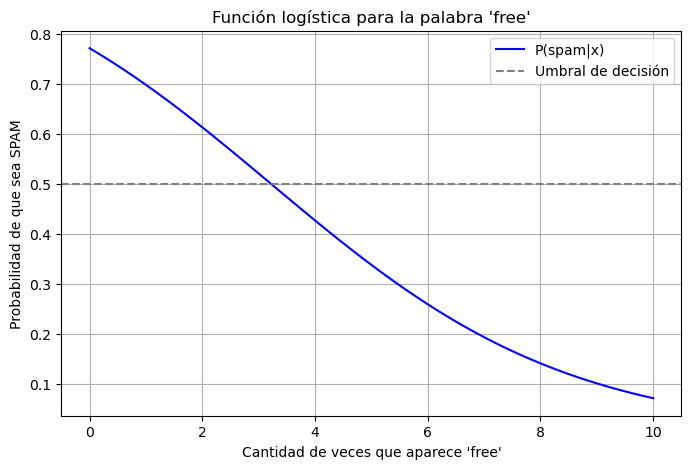

Modelo: P(spam|x) = 1 / (1 + exp(-(1.21 + -0.38 * x)))


In [15]:
# Gráfico de la función sigmoide
plt.figure(figsize=(8, 5))
plt.plot(x_vals, sigmoid, label='P(spam|x)', color='blue')
plt.axhline(0.5, color='gray', linestyle='--', label='Umbral de decisión')
plt.title("Función logística para la palabra 'free'")
plt.xlabel("Cantidad de veces que aparece 'free'")
plt.ylabel("Probabilidad de que sea SPAM")
plt.grid(True)
plt.legend()
plt.show()

# Mostrar modelo aprendido
print(f"Modelo: P(spam|x) = 1 / (1 + exp(-({theta_0:.2f} + {theta_1:.2f} * x)))")